In [1]:
import pickle
import numpy as np
import pandas as pd
import scipy
import torch
import matplotlib.pyplot as plt
from gurobipy import GRB
from plots import *
from ems_data import *
from simulation import *
from neural_network import *
from mip_models import *

TRAINING_METRICS = ['coverage_9min', 'coverage_15min', 'survival_rate', 'response_time_mean', 'response_time_median', 'response_time_90th_percentile']
FACILITY_CAPACITY = 5
TIME_LIMIT = 60  # Set to 600 for final results
SUCCESS_PROB = 0.9

def plot_metric(X: np.ndarray, y: np.ndarray, metric: str):
    """Plot histogram and box plots side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].hist(y, bins=100)
    ax[0].set_xlabel(metric)
    ax[0].set_ylabel("Frequency")
    plot_metric_by_ambulance_count(X, y, metric, ax=ax[1])
    return fig, ax

def best_solution_from_dataset(dataset: pd.DataFrame, n_ambulances: int, metric: str) -> tuple[pd.Series, pd.Series]:
    """Finds the best solution w.r.t. a metric for a given maximum number of ambulances."""
    Y = dataset[METRICS]
    X = dataset.drop(columns=METRICS)
    indices = np.where(X.sum(axis=1) <= n_ambulances)[0]
    argmin_or_argmax = np.argmin if 'response_time' in metric else np.argmax
    y = Y[metric]
    best_idx = indices[argmin_or_argmax(y[indices])]
    return X.iloc[best_idx], Y.iloc[best_idx]

def remove_outliers_at_each_ambulance_count(X, y, percent=5, tail='right'):
    """For each total number of ambulances, isolate samples with that total and remove outliers.

    Parameters
    ----------
    X, y : np.ndarray
        The dataset.
    
    percent : int, optional
        Percentage of data to remove.
    
    tail : {'left', 'right', 'both'}, optional
        Which tail to remove outliers from.

        For maximization problems, use 'left'. For minimization problems, use 'right'.

    Returns
    -------
    X_new, y_new : np.ndarray
        The dataset with outliers removed.
    """
    X_sum = X.sum(axis=1)
    min_ambulances = X_sum.min()
    max_ambulances = X_sum.max()
    keep = np.full(X.shape[0], False)
    for total in range(min_ambulances, max_ambulances+1):
        left_threshold = -np.inf
        right_threshold = np.inf
        if tail == 'right':
            right_threshold = np.percentile(y[X_sum == total], 100-percent)
        elif tail == 'left':
            left_threshold = np.percentile(y[X_sum == total], percent)
        elif tail == 'both':
            left_threshold = np.percentile(y[X_sum == total], percent/2)
            right_threshold = np.percentile(y[X_sum == total], 1 - percent/2)
        keep |= (X_sum == total) & (left_threshold < y) & (y < right_threshold)
    return X[keep], y[keep]

def rescale(x: np.ndarray, min: float = 0, max: float = 1) -> np.ndarray:
    """Shift and scale data to the range [min, max]."""
    return (x - x.min()) / (x.max() - x.min()) * (max - min) + min

print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

NVIDIA GeForce GTX 1070


device(type='cuda')

# stations: 17
# demand nodes: 440


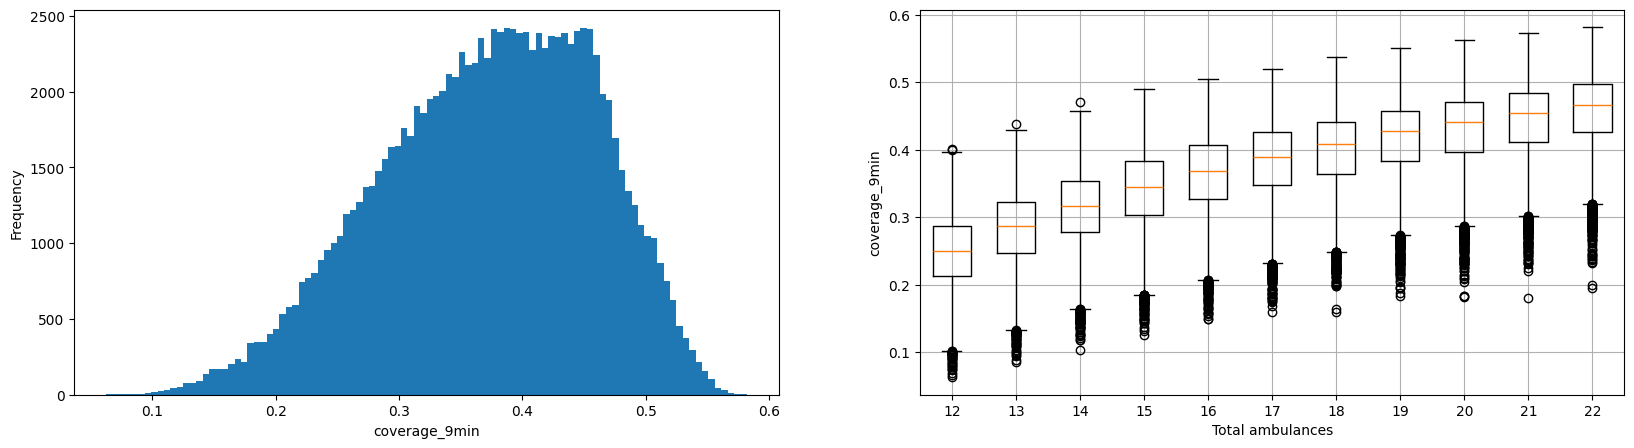

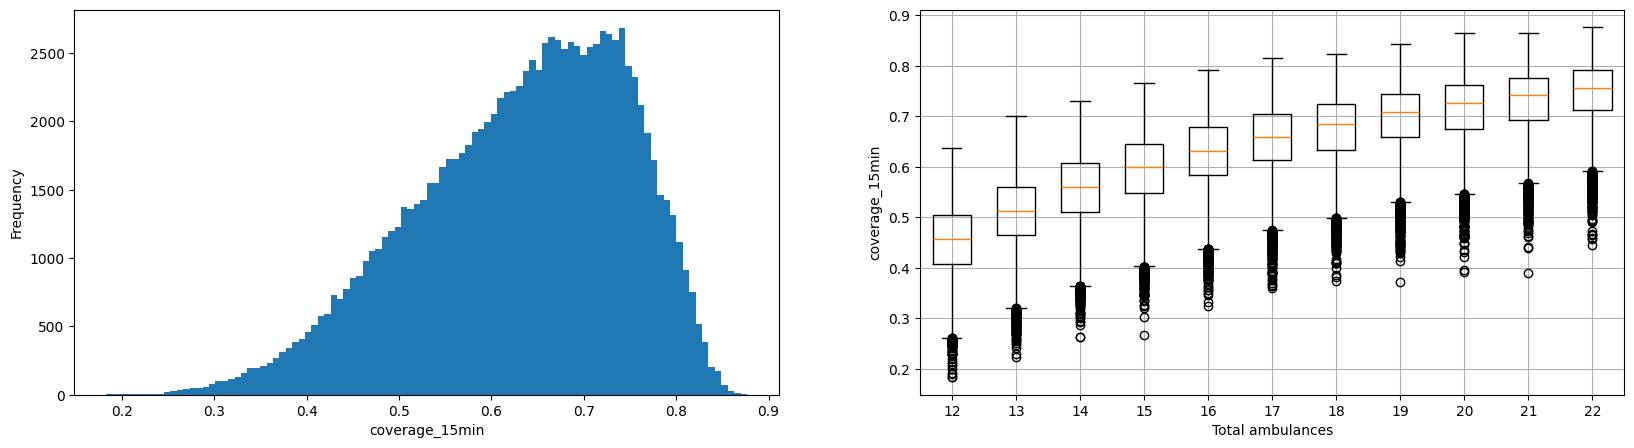

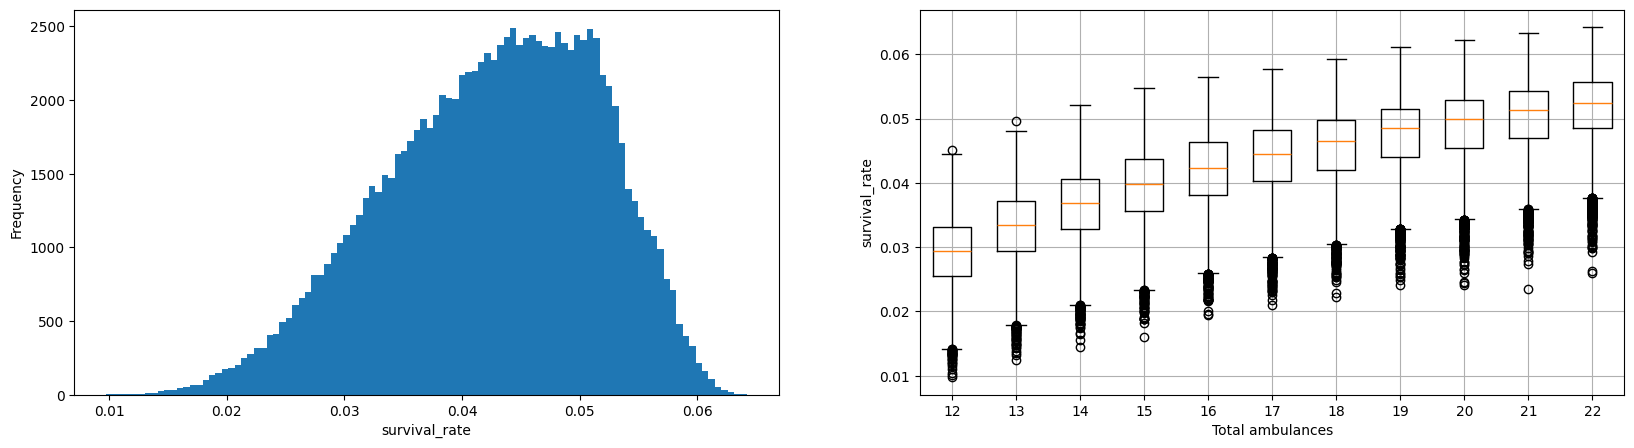

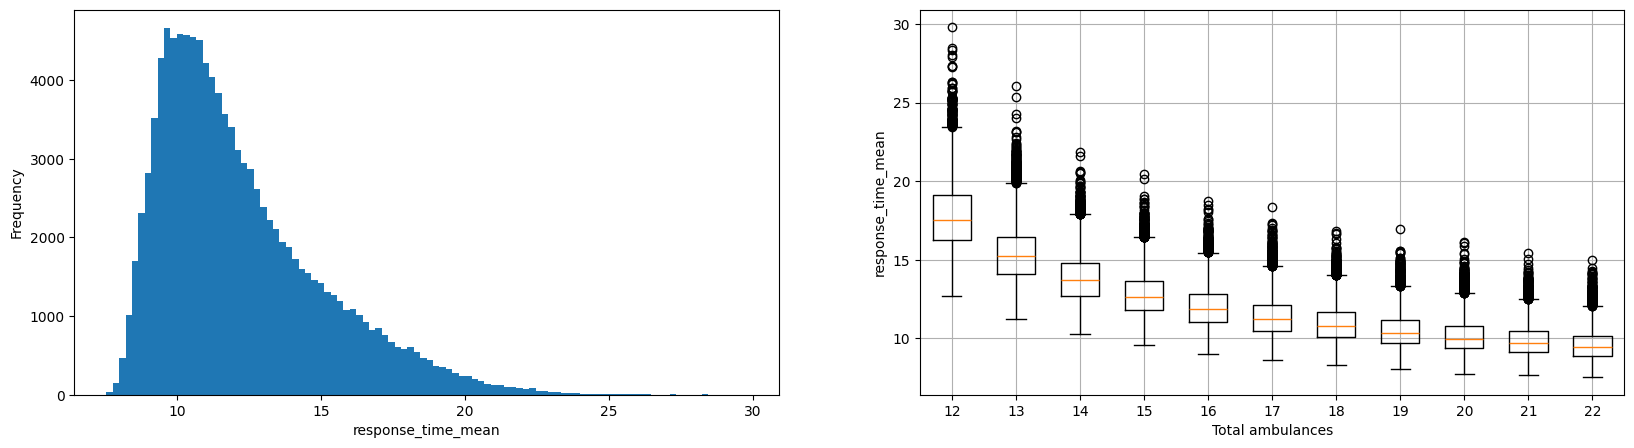

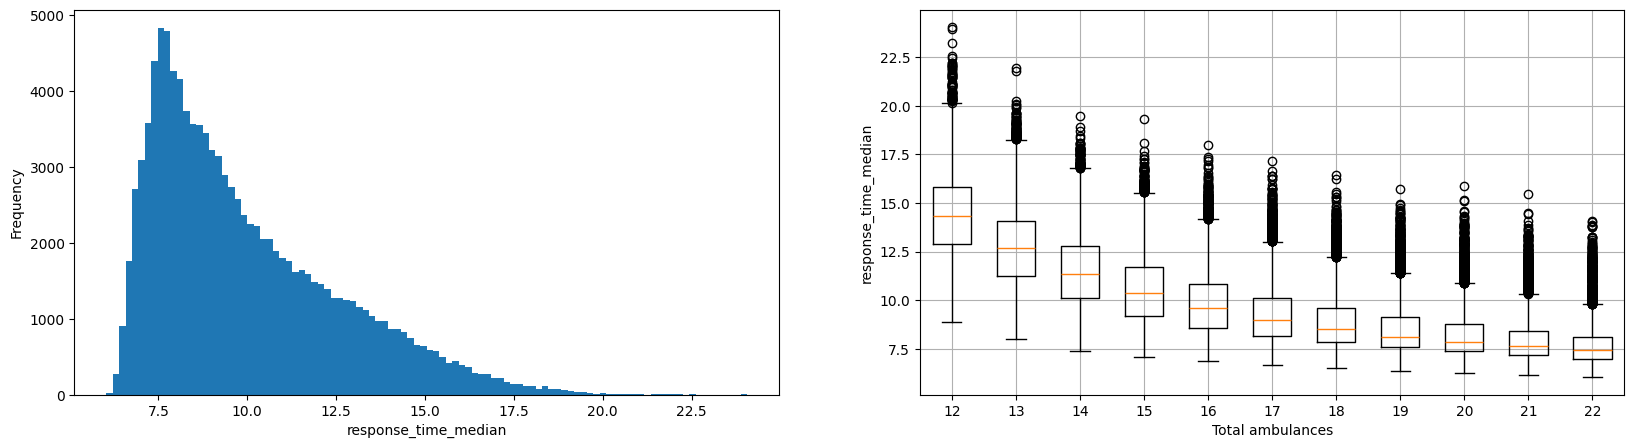

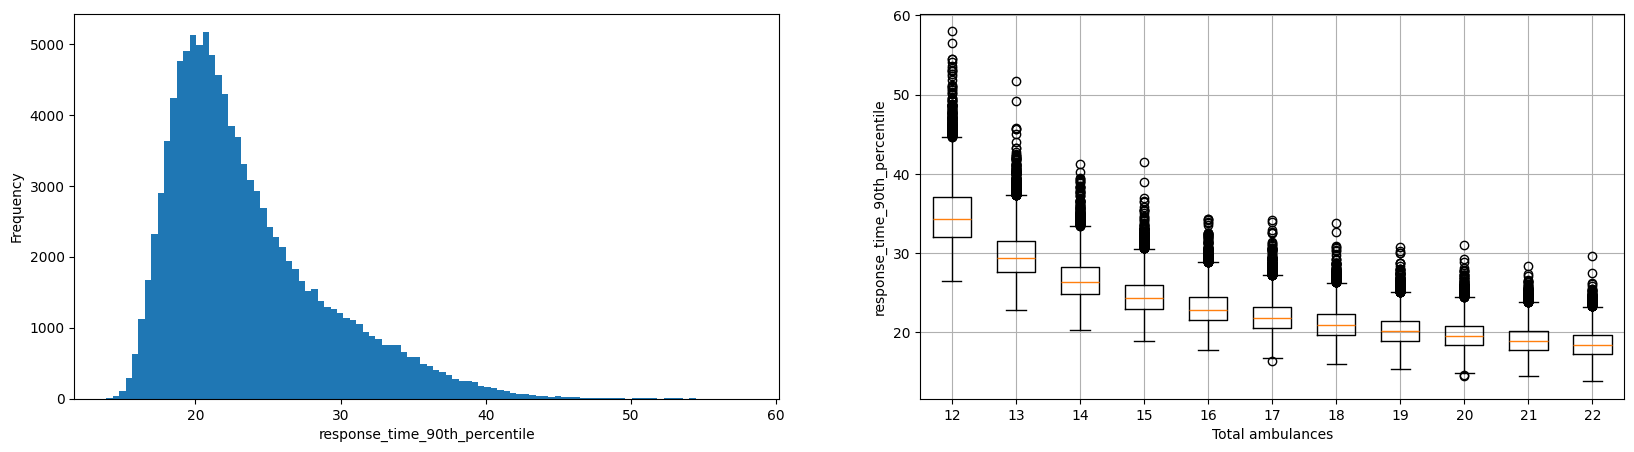

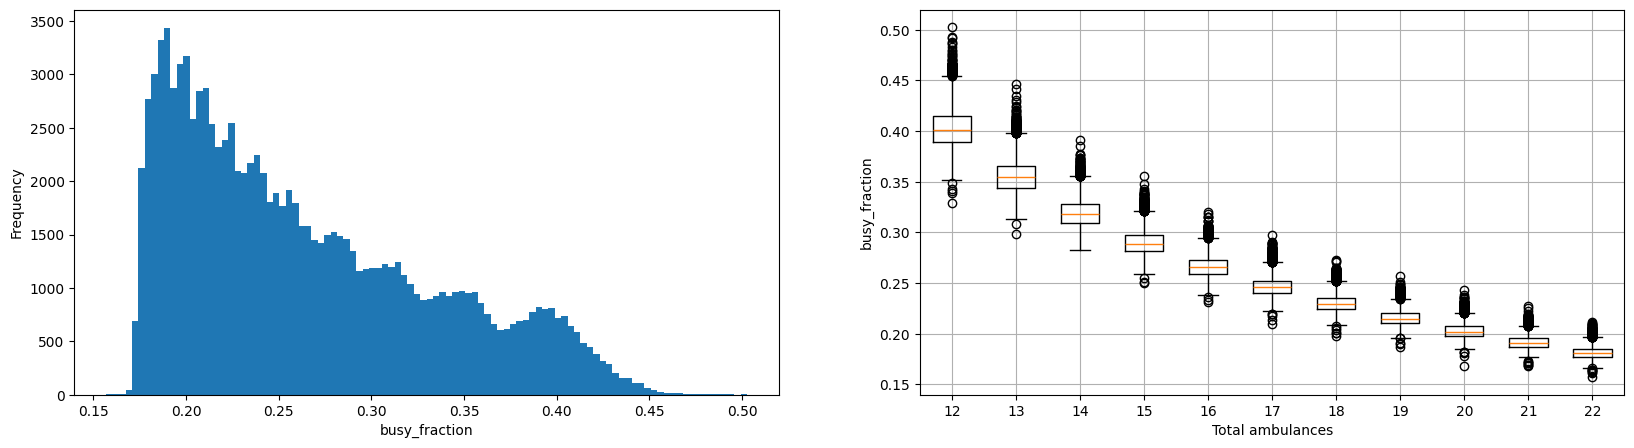

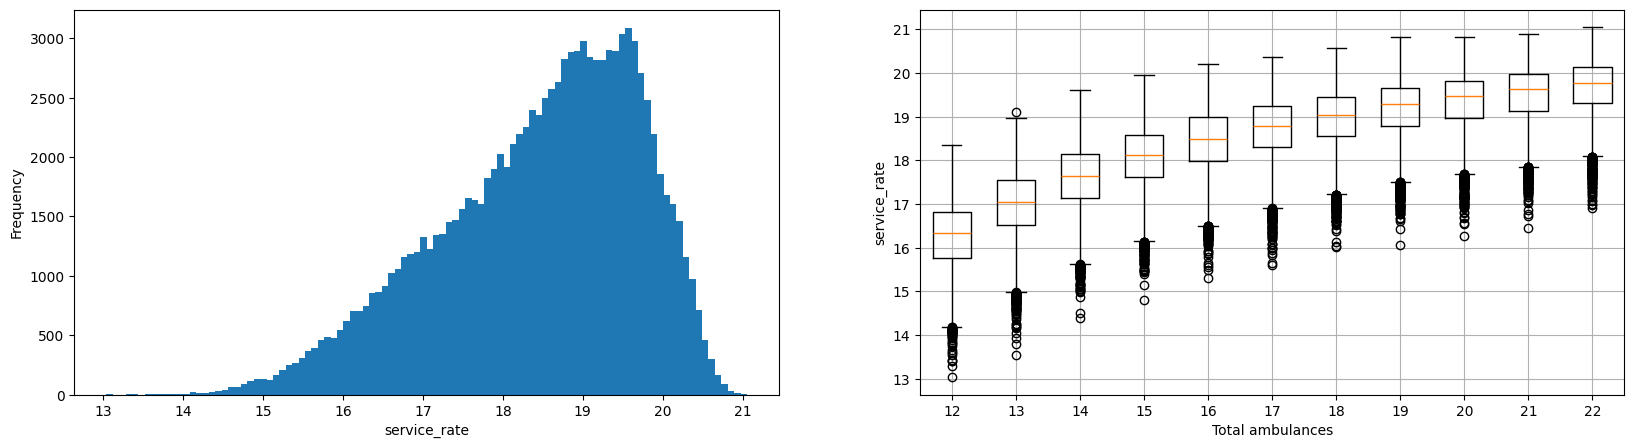

In [2]:
N_AMBULANCES = 17  # 14, 17, 20

region_id = 3
with open('ems_data.pkl', 'rb') as f:
    ems_data = pickle.load(f)
ems_data.region_id = region_id
demand_nodes = EMSData.read_patient_locations(region_id, test_id=0)
n_stations = len(ems_data.stations)
n_demand_nodes = len(demand_nodes)
print(f"# stations: {n_stations}")
print(f"# demand nodes: {n_demand_nodes}")
distance = Simulation.driving_distance(demand_nodes, ems_data.stations)
sim = Simulation(ems_data, n_days=100, n_replications=5)

dataset = pd.read_csv(f'dataset{region_id}.csv')
Y = dataset[METRICS].to_numpy()
X = dataset.drop(columns=METRICS).to_numpy()

for metric in METRICS:
    y = Y[:, METRICS.index(metric)]
    plot_metric(X, y, metric)

In [3]:
# Estimate busy_fraction and service_rate
BUSY_FRACTION = {}
SERVICE_RATE = {}
for n_ambulances in [14, 17, 20]:
    # Busy fraction used by MEXCLP so estimate using best w.r.t. coverage_15min
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'coverage_15min')
    BUSY_FRACTION[n_ambulances] = y['busy_fraction']
    # Service rate used by p-median + queueing model so estimate using best w.r.t. response_time_mean
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'response_time_mean')
    SERVICE_RATE[n_ambulances] = y['service_rate']
print(f"BUSY_FRACTION = {BUSY_FRACTION}\nSERVICE_RATE = {SERVICE_RATE}")

BUSY_FRACTION = {14: 0.288004162638955, 17: 0.2288075320373579, 20: 0.1880189046214391}
SERVICE_RATE = {14: 19.377337143021244, 17: 20.266597902930563, 20: 20.77655572881174}


# Baselines
- Best solutions from the dataset w.r.t `coverage_15min`, `survival_rate`, `response_time_mean`
- MEXCLP
- $p$-Median with queueing

In [4]:
all_results = []  # Columns: ['model_name', 'n_ambulances', *METRICS]

In [5]:
# Best solutions from dataset
for metric in ['coverage_15min', 'survival_rate', 'response_time_mean']:
    x, y = best_solution_from_dataset(dataset, N_AMBULANCES, metric)
    model_name = f'best_{metric}'
    n_ambulances = x.sum()
    new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
    all_results.append(new_row)

In [6]:
# MEXCLP
solution = mexclp(
    n_ambulances=N_AMBULANCES,
    distance=distance,
    threshold=MEXCLP_THRESHOLD_15MIN,
    busy_fraction=BUSY_FRACTION[N_AMBULANCES],
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-17
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 441 rows, 7497 columns and 8012 nonzeros
Model fingerprint: 0x854b1fe5
Variable types: 0 continuous, 7497 integer (7480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-13, 2e-03]
  Bounds range     [1e+00, 5e+00]
  RHS range        [2e+01, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 66 rows and 4905 columns
Presolve time: 0.01s
Presolved: 375 rows, 2592 columns, 3107 nonzeros
Variable types: 0 continuous, 2592 integer (2575 binary)
Found heuristic solution: objective 0.5373441

Root relaxation: objective 7.608170e-01, 1106 iterations, 0.01 seconds (0.01 work uni

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.510609,0.797993,0.056975,8.957304,6.788783,17.828647,0.229816,20.125759
1,0.510976,0.805608,0.056683,8.865693,6.778872,17.460580,0.229889,20.161635
2,0.505384,0.802279,0.055924,9.007036,6.847298,17.854756,0.232095,20.233334
3,0.517502,0.809847,0.057217,8.807632,6.690223,17.239560,0.225298,20.356328
4,0.511333,0.802837,0.056452,8.908183,6.822915,17.698103,0.229331,20.245132


In [7]:
model_name = 'MEXCLP'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

In [8]:
# p-Median with queuing
solution = pmedian_with_queuing(
    n_ambulances=N_AMBULANCES,
    distance=distance,
    arrival_rate=ems_data.avg_calls_per_day,
    service_rate=SERVICE_RATE[N_AMBULANCES],
    success_prob=SUCCESS_PROB,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 8006 rows, 7565 columns and 30226 nonzeros
Model fingerprint: 0x7e22147a
Variable types: 7480 continuous, 85 integer (85 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+01]
  Objective range  [8e-04, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve time: 0.02s
Presolved: 8006 rows, 7565 columns, 30226 nonzeros
Variable types: 7480 continuous, 85 integer (85 binary)
Found heuristic solution: objective 24.6379520

Root relaxation: objective 6.765236e+00, 252 iterations, 0.02 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.7652

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.536311,0.796682,0.058923,9.007217,6.465983,17.858174,0.225453,20.434107
1,0.522153,0.794618,0.057385,9.240310,6.671306,18.345404,0.228856,20.537608
2,0.536672,0.802720,0.059405,8.802981,6.505066,17.444319,0.223166,20.728015
3,0.537528,0.811984,0.059308,8.819401,6.458513,17.351250,0.228146,20.599406
4,0.523048,0.796348,0.058238,9.048942,6.572996,17.773524,0.228477,20.429709


In [9]:
model_name = 'p-Median + Queueing'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

In [10]:
# Results so far
pd.DataFrame(all_results, columns=['model_name', 'n_ambulances', *METRICS])

,model_name,n_ambulances,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,best_coverage_15min,17,0.503961,0.814825,0.056267,8.638252,6.895237,16.413613,0.228808,20.266598
1,best_survival_rate,17,0.520308,0.805761,0.057650,8.687876,6.713034,17.091606,0.229152,20.341852
2,best_response_time_mean,17,0.503961,0.814825,0.056267,8.638252,6.895237,16.413613,0.228808,20.266598
3,MEXCLP,17,0.511161,0.803713,0.056650,8.909170,6.785618,17.616329,0.229286,20.224438
4,p-Median + Queueing,17,0.531142,0.800470,0.058652,8.983770,6.534773,17.754534,0.226820,20.545769


# Coverage

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='coverage_15min (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='coverage_15min (transformed)'>],
       dtype=object))

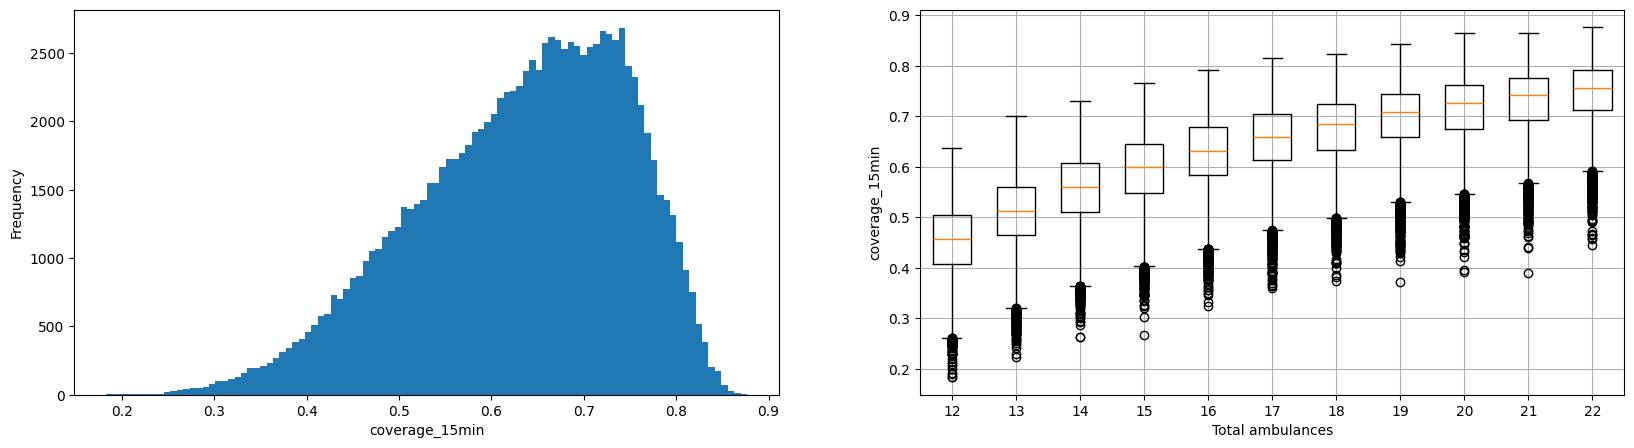

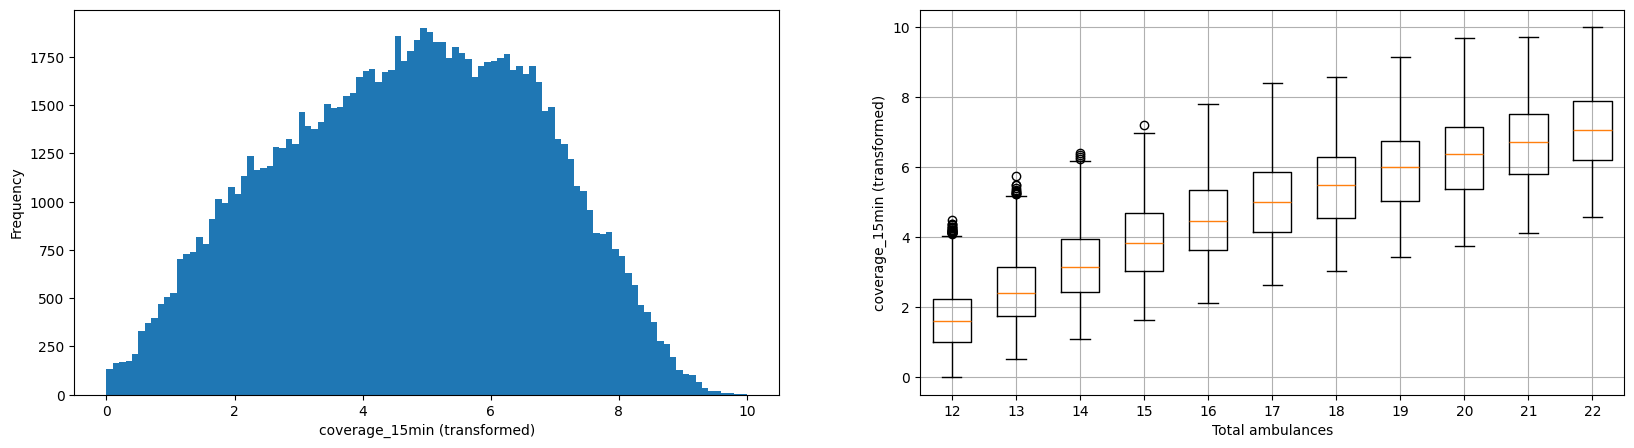

In [11]:
Y = dataset[METRICS].to_numpy()
X = dataset.drop(columns=METRICS).to_numpy()
metric = 'coverage_15min'
y = Y[:, METRICS.index(metric)]
plot_metric(X, y, metric)
X, y = remove_outliers_at_each_ambulance_count(X, y, percent=5, tail='left')
y = scipy.stats.boxcox(y)[0]
# Box-Cox transformation generally turns probabilities into negative values with a small range
# The modified sigmoid function is only nonlinear for positive values
# To deal with negative values and increase the range, we shift and scale
y = rescale(y, 0, 10)
plot_metric(X, y, f'{metric} (transformed)')

In [12]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[200, 200],
    final_hidden_activation=ModifiedSigmoid(),
    name='simcoe_coverage'
).to(device)

# Begin training with Adam
mlp.fit(X_pt, y_pt)

# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)

# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 61%|██████    | 61/100 [02:10<01:23,  2.14s/epoch, best_val_loss=0.0189, train_loss=0.114, val_loss=0.0229]


Early stopping


 63%|██████▎   | 63/100 [02:08<01:15,  2.04s/epoch, best_val_loss=0.00448, train_loss=0.00449, val_loss=0.00481]


Early stopping


 43%|████▎     | 43/100 [01:20<01:46,  1.86s/epoch, best_val_loss=0.00368, train_loss=0.00356, val_loss=0.00368]

Early stopping


In [13]:
weights, biases = MLP.load_npz('simcoe_coverage.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3618 rows, 1234 columns and 50251 nonzeros
Model fingerprint: 0x396e2855
Variable types: 1017 continuous, 217 integer (200 binary)
Coefficient statistics:
  Matrix range     [3e-06, 2e+01]
  Objective range  [1e-01, 2e-01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [4e-04, 2e+01]
Presolve removed 1586 rows and 217 columns
Presolve time: 0.13s
Presolved: 2032 rows, 1017 columns, 47279 nonzeros
Variable types: 800 continuous, 217 integer (200 binary)

Root relaxation: objective 1.187770e+01, 430 iterations, 0.02 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.87770

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.547361,0.839012,0.059881,8.230533,6.420640,15.882615,0.226918,20.766674
1,0.549610,0.837537,0.060993,8.275171,6.335773,16.200670,0.222011,20.688272
2,0.540188,0.829361,0.059637,8.416016,6.479337,16.427632,0.225509,20.575164
3,0.528155,0.826295,0.058273,8.469374,6.580650,16.183642,0.229120,20.417436
4,0.542571,0.838449,0.059374,8.319571,6.452246,15.762083,0.222052,20.617379


In [14]:
model_name = 'MLP-Coverage'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

pd.DataFrame(all_results, columns=['model_name', 'n_ambulances', *METRICS])

,model_name,n_ambulances,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,best_coverage_15min,17,0.503961,0.814825,0.056267,8.638252,6.895237,16.413613,0.228808,20.266598
1,best_survival_rate,17,0.520308,0.805761,0.057650,8.687876,6.713034,17.091606,0.229152,20.341852
2,best_response_time_mean,17,0.503961,0.814825,0.056267,8.638252,6.895237,16.413613,0.228808,20.266598
3,MEXCLP,17,0.511161,0.803713,0.056650,8.909170,6.785618,17.616329,0.229286,20.224438
4,p-Median + Queueing,17,0.531142,0.800470,0.058652,8.983770,6.534773,17.754534,0.226820,20.545769
5,MLP-Coverage,17,0.541577,0.834131,0.059632,8.342133,6.453729,16.091328,0.225122,20.612985


# Survival

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='survival_rate (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='survival_rate (transformed)'>],
       dtype=object))

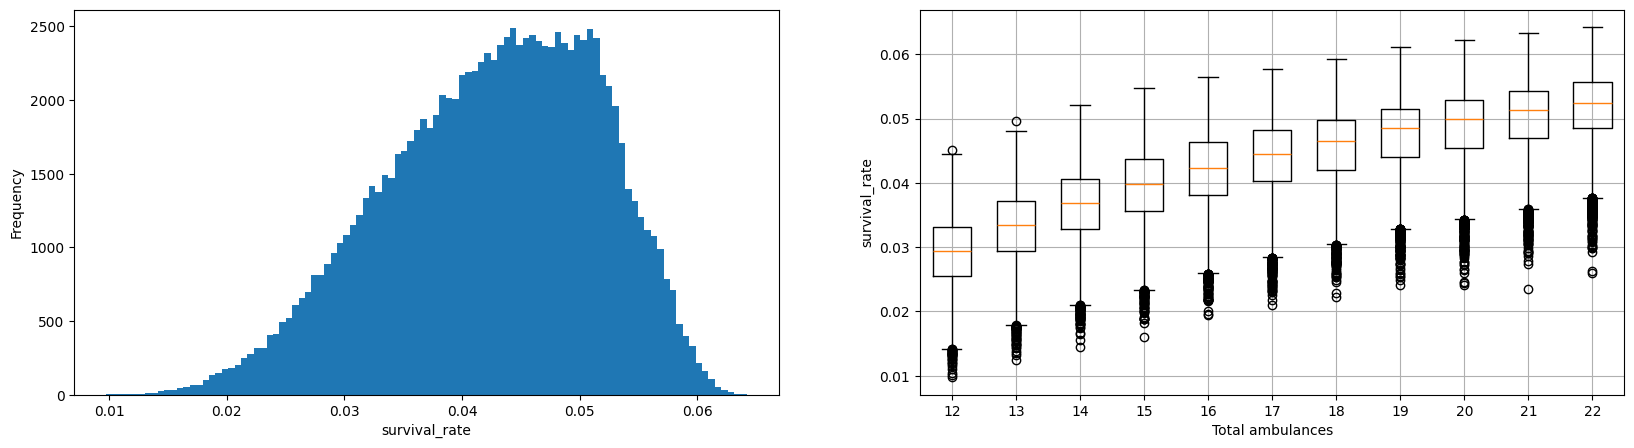

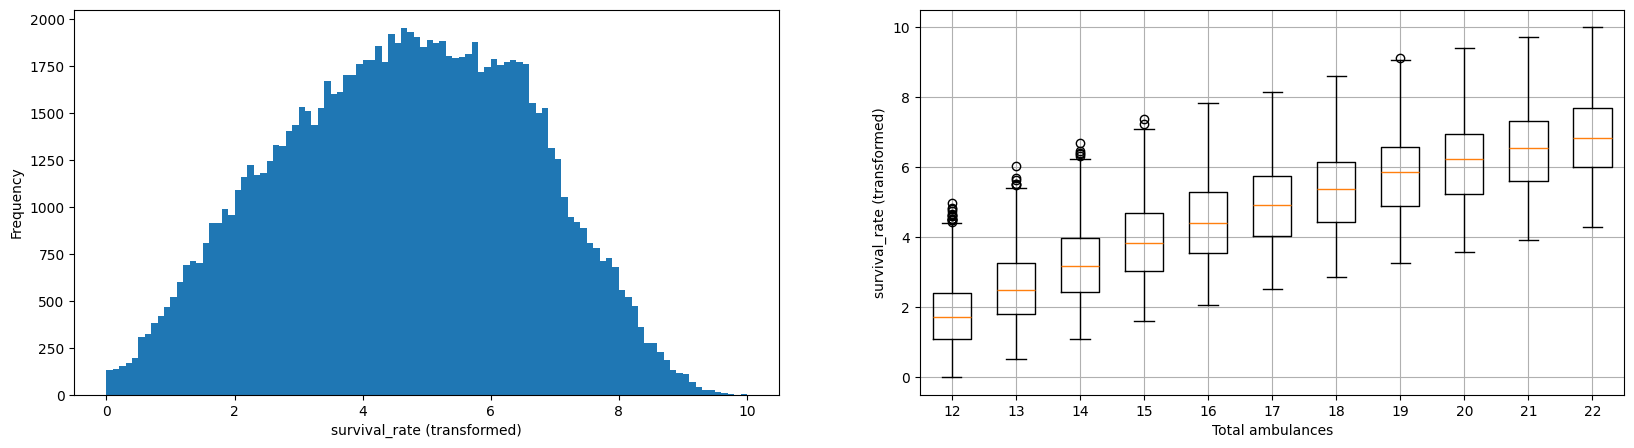

In [15]:
Y = dataset[METRICS].to_numpy()
X = dataset.drop(columns=METRICS).to_numpy()
metric = 'survival_rate'
y = Y[:, METRICS.index(metric)]
plot_metric(X, y, metric)
X, y = remove_outliers_at_each_ambulance_count(X, y, percent=5, tail='left')
y = scipy.stats.boxcox(y)[0]
# Box-Cox transformation generally turns probabilities into negative values with a small range
# The modified sigmoid function is only nonlinear for positive values
# To deal with negative values and increase the range, we shift and scale
y = rescale(y, 0, 10)
plot_metric(X, y, f'{metric} (transformed)')

In [16]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[200, 200],
    final_hidden_activation=ModifiedSigmoid(),
    name='simcoe_survival'
).to(device)

# Begin training with Adam
mlp.fit(X_pt, y_pt)

# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)

# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 99%|█████████▉| 99/100 [03:32<00:02,  2.15s/epoch, best_val_loss=0.0175, train_loss=0.0964, val_loss=0.0277]


Early stopping


 65%|██████▌   | 65/100 [02:13<01:11,  2.06s/epoch, best_val_loss=0.00475, train_loss=0.00497, val_loss=0.00487]


Early stopping


 38%|███▊      | 38/100 [01:10<01:55,  1.87s/epoch, best_val_loss=0.0042, train_loss=0.0041, val_loss=0.0042]   

Early stopping


In [17]:
weights, biases = MLP.load_npz('simcoe_survival.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3618 rows, 1234 columns and 50251 nonzeros
Model fingerprint: 0xd4fc89d2
Variable types: 1017 continuous, 217 integer (200 binary)
Coefficient statistics:
  Matrix range     [8e-07, 2e+01]
  Objective range  [8e-02, 1e-01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [4e-03, 2e+01]
Presolve removed 1583 rows and 217 columns
Presolve time: 0.07s
Presolved: 2035 rows, 1017 columns, 47286 nonzeros
Variable types: 800 continuous, 217 integer (200 binary)

Root relaxation: objective 1.043910e+01, 411 iterations, 0.01 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   10.43910

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.552709,0.826769,0.060813,8.365516,6.353897,16.474650,0.220821,20.898958
1,0.538775,0.822870,0.059442,8.426715,6.408949,16.437477,0.222112,20.796066
2,0.543236,0.819547,0.060434,8.481842,6.355118,16.554691,0.227169,20.684972
3,0.544127,0.827847,0.060096,8.381786,6.424416,16.206088,0.220391,20.825135
4,0.552466,0.830694,0.060724,8.237638,6.400907,15.948835,0.218016,20.941100


In [18]:
model_name = 'MLP-Survival'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

pd.DataFrame(all_results, columns=['model_name', 'n_ambulances', *METRICS])

,model_name,n_ambulances,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,best_coverage_15min,17,0.503961,0.814825,0.056267,8.638252,6.895237,16.413613,0.228808,20.266598
1,best_survival_rate,17,0.520308,0.805761,0.057650,8.687876,6.713034,17.091606,0.229152,20.341852
2,best_response_time_mean,17,0.503961,0.814825,0.056267,8.638252,6.895237,16.413613,0.228808,20.266598
3,MEXCLP,17,0.511161,0.803713,0.056650,8.909170,6.785618,17.616329,0.229286,20.224438
4,p-Median + Queueing,17,0.531142,0.800470,0.058652,8.983770,6.534773,17.754534,0.226820,20.545769
5,MLP-Coverage,17,0.541577,0.834131,0.059632,8.342133,6.453729,16.091328,0.225122,20.612985
6,MLP-Survival,17,0.546262,0.825545,0.060302,8.378699,6.388657,16.324348,0.221702,20.829246


# p-Median + Queueing

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='response_time_mean (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='response_time_mean (transformed)'>],
       dtype=object))

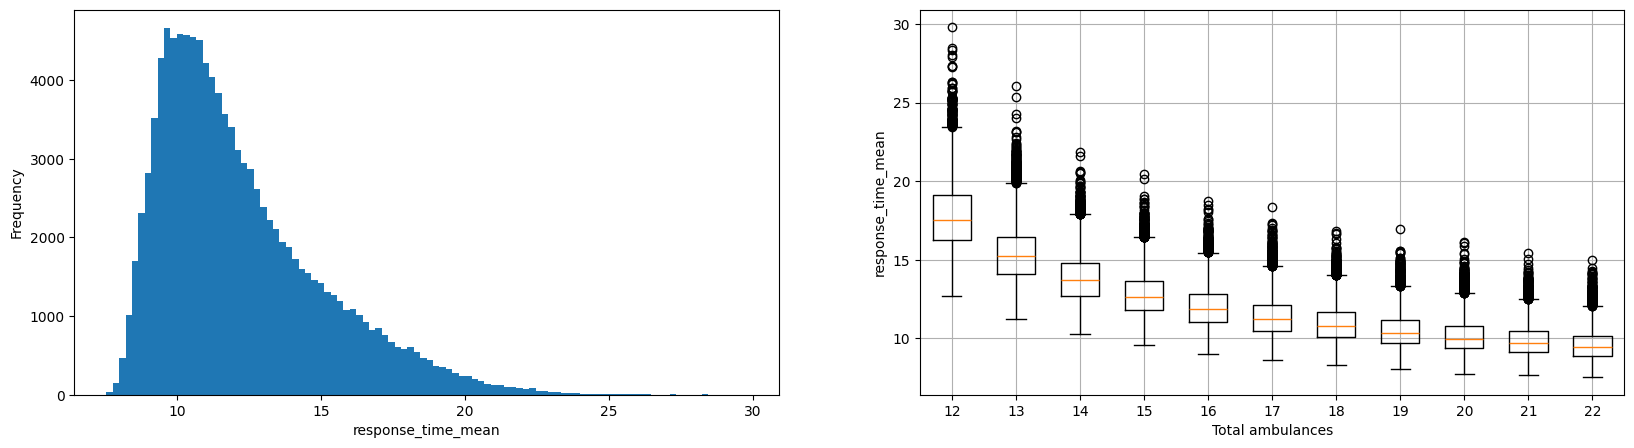

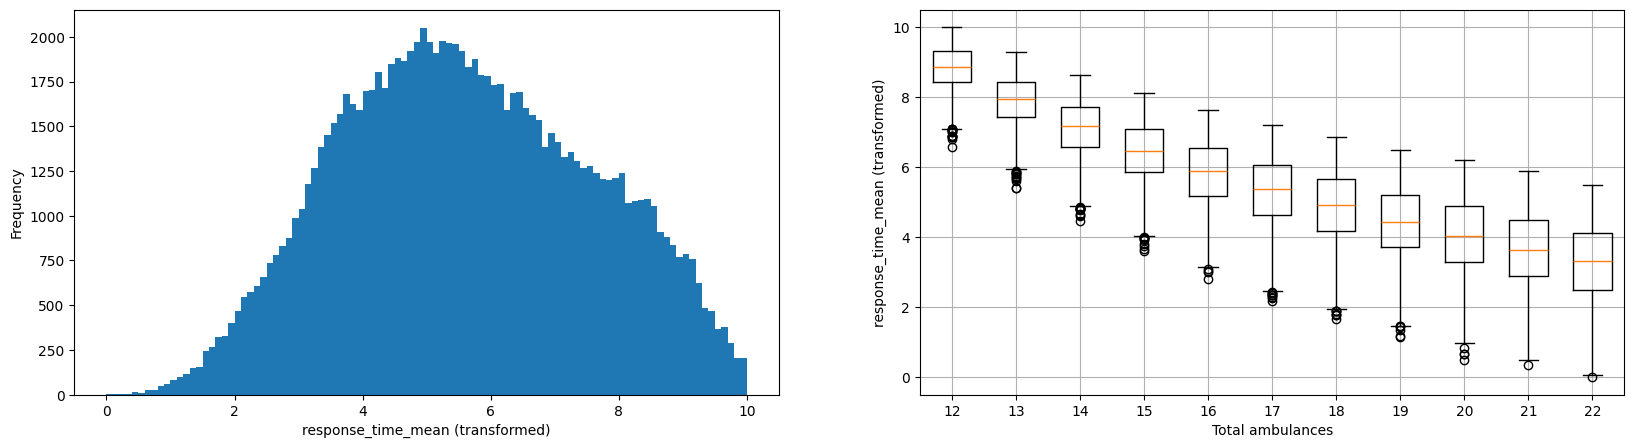

In [19]:
Y = dataset[METRICS].to_numpy()
X = dataset.drop(columns=METRICS).to_numpy()
metric = 'response_time_mean'
y = Y[:, METRICS.index(metric)]
plot_metric(X, y, metric)
X, y = remove_outliers_at_each_ambulance_count(X, y, percent=5, tail='right')
y = scipy.stats.boxcox(y)[0]
y = rescale(y, 0, 10)
plot_metric(X, y, f'{metric} (transformed)')

In [20]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[200, 200],
    name='simcoe_pmedian'
).to(device)

# Begin training with Adam
mlp.fit(X_pt, y_pt)

# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)

# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 33%|███▎      | 33/100 [01:05<02:12,  1.98s/epoch, best_val_loss=0.0795, train_loss=0.139, val_loss=0.302] 


Early stopping


 90%|█████████ | 90/100 [02:42<00:18,  1.80s/epoch, best_val_loss=0.00527, train_loss=0.00546, val_loss=0.00561]


Early stopping


 48%|████▊     | 48/100 [01:16<01:23,  1.60s/epoch, best_val_loss=0.00377, train_loss=0.00364, val_loss=0.00377]

Early stopping


In [21]:
weights, biases = MLP.load_npz('simcoe_pmedian.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1620 rows, 1234 columns and 46254 nonzeros
Model fingerprint: 0x8c821234
Variable types: 1017 continuous, 217 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e-06, 1e+01]
  Objective range  [3e-01, 1e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e-03, 2e+01]
Presolve removed 622 rows and 419 columns
Presolve time: 0.06s
Presolved: 998 rows, 815 columns, 45212 nonzeros
Variable types: 599 continuous, 216 integer (199 binary)
Found heuristic solution: objective 10.2715051
Found heuristic solution: objective 10.0889524

Root relaxation: objective 7.023113e-01, 346 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.547576,0.840985,0.060526,8.185348,6.398857,15.669882,0.220414,20.806544
1,0.534211,0.834968,0.058748,8.372995,6.585550,15.821162,0.230165,20.576468
2,0.541475,0.832053,0.059482,8.372080,6.497166,16.208966,0.223007,20.595069
3,0.529712,0.827449,0.058863,8.452251,6.592828,16.481423,0.229444,20.618348
4,0.548740,0.840799,0.060207,8.182812,6.395120,15.576171,0.222509,20.762366


In [22]:
model_name = 'MLP-pMedian'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

pd.DataFrame(all_results, columns=['model_name', 'n_ambulances', *METRICS])

,model_name,n_ambulances,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,best_coverage_15min,17,0.503961,0.814825,0.056267,8.638252,6.895237,16.413613,0.228808,20.266598
1,best_survival_rate,17,0.520308,0.805761,0.057650,8.687876,6.713034,17.091606,0.229152,20.341852
2,best_response_time_mean,17,0.503961,0.814825,0.056267,8.638252,6.895237,16.413613,0.228808,20.266598
3,MEXCLP,17,0.511161,0.803713,0.056650,8.909170,6.785618,17.616329,0.229286,20.224438
4,p-Median + Queueing,17,0.531142,0.800470,0.058652,8.983770,6.534773,17.754534,0.226820,20.545769
5,MLP-Coverage,17,0.541577,0.834131,0.059632,8.342133,6.453729,16.091328,0.225122,20.612985
6,MLP-Survival,17,0.546262,0.825545,0.060302,8.378699,6.388657,16.324348,0.221702,20.829246
7,MLP-pMedian,17,0.540343,0.835251,0.059565,8.313097,6.493904,15.951521,0.225108,20.671759
